In [24]:

import os, math, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# Optional speedups for T4 GPU:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# tf.config.optimizer.set_jit(True)


In [25]:

# ==== Load NSL-KDD ====
DATA_DIR = "./nsl_kdd"
os.makedirs(DATA_DIR, exist_ok=True)
URL_TRAIN = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
URL_TEST  = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"

train_path = os.path.join(DATA_DIR, "KDDTrain+.txt")
test_path  = os.path.join(DATA_DIR, "KDDTest+.txt")

def fetch(url, dest):
    if not os.path.exists(dest):
        import urllib.request
        print(f"Downloading {os.path.basename(dest)} ...")
        urllib.request.urlretrieve(url, dest)

fetch(URL_TRAIN, train_path)
fetch(URL_TEST, test_path)

cols = [
 'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
 'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
 'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
 'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
 'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
 'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
 'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
 'label','difficulty'
]

def load_nsl_kdd(train_p, test_p):
    df_train = pd.read_csv(train_p, names=cols)
    df_test  = pd.read_csv(test_p,  names=cols)
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df.drop_duplicates()
    df['label'] = df['label'].astype(str).str.strip()
    return df

df = load_nsl_kdd(train_path, test_path)
print("Data shape:", df.shape)


Data shape: (147907, 43)


In [26]:

# ==== Targets ====
# Binary
df['label_binary'] = (df['label'] != 'normal').astype(int)

# 5-class mapping
DOS = set(['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm'])
PROBE = set(['satan','ipsweep','nmap','portsweep','mscan','saint'])
R2L = set(['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient',
           'spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named'])
U2R = set(['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps'])

def map_5c(lbl):
    if lbl == 'normal': return 'Normal'
    b = lbl.split('.')[0]
    if b in DOS: return 'DoS'
    if b in PROBE: return 'Probe'
    if b in R2L: return 'R2L'
    if b in U2R: return 'U2R'
    return 'DoS'

df['label_5c'] = df['label'].apply(map_5c)
print(df['label_5c'].value_counts())


label_5c
Normal    76967
DoS       52987
Probe     13954
R2L        3880
U2R         119
Name: count, dtype: int64


In [27]:

# ==== No-leak preprocessing: split first, then fit transforms on train only ====
cat_cols = ['protocol_type','service','flag']
num_cols = [c for c in cols if c not in (cat_cols + ['label','difficulty'])]

# Build arrays to index after splitting
y5_all = df['label_5c'].astype('category').cat.codes.values
ybin_all = df['label_binary'].values
X_raw = df[num_cols + cat_cols].copy()

# Split by 5-class (stratified) so we keep minorities representation
X_train_raw, X_test_raw, y_train5, y_test5, y_trainbin, y_testbin = train_test_split(
    X_raw, y5_all, ybin_all, test_size=0.2, random_state=42, stratify=y5_all
)

# Numeric processing on TRAIN only
train_num = X_train_raw[num_cols].apply(pd.to_numeric, errors='coerce').replace([np.inf,-np.inf], np.nan)
test_num  = X_test_raw[num_cols].apply(pd.to_numeric, errors='coerce').replace([np.inf,-np.inf], np.nan)
train_num = train_num.fillna(train_num.median())
test_num  = test_num.fillna(train_num.median())  # use train medians

num_min = train_num.min()
num_rng = (train_num.max() - train_num.min()).replace(0, 1.0)
X_train_num = (train_num - num_min) / num_rng
X_test_num  = (test_num  - num_min) / num_rng

# Categorical encoding on TRAIN only
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train_cat = ord_enc.fit_transform(X_train_raw[cat_cols])
X_test_cat  = ord_enc.transform(X_test_raw[cat_cols])

# Final matrices
X_train = np.hstack([X_train_num.values, X_train_cat]).astype(np.float32)
X_test  = np.hstack([X_test_num.values,  X_test_cat ]).astype(np.float32)

print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (118325, 41) (29582, 41)


In [28]:

# ==== Plot helpers ====
def plot_training(history, title="Training"):
    plt.figure(figsize=(6,4))
    if "loss" in history.history: plt.plot(history.history["loss"], label="loss")
    if "val_loss" in history.history: plt.plot(history.history["val_loss"], label="val_loss")
    if "accuracy" in history.history: plt.plot(history.history["accuracy"], label="accuracy")
    if "val_accuracy" in history.history: plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend(); plt.grid(True); plt.show()

def show_confusion(y_true, y_pred, labels, class_names=None, title="Confusion Matrix", normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
    fig.colorbar(im, ax=ax)
    if class_names is None: class_names = labels
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True', xlabel='Predicted', title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() if cm.size else 0) / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout(); plt.show()


In [29]:

# ==== Model ====
def build_model(n_features, conv_filters=30, lstm_units=120, dense_units=512,
                lr=1e-3, dropout=0.2, seq_len=1, n_out=1):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.Conv1D(filters=conv_filters, kernel_size=5, padding="same", activation="relu")(inp)
    x = layers.LSTM(lstm_units, dropout=dropout, return_sequences=False)(x)
    x = layers.Dense(dense_units, activation="sigmoid")(x)
    if n_out == 1:
        out = layers.Dense(1, activation="sigmoid")(x); loss = "binary_crossentropy"
    else:
        out = layers.Dense(n_out, activation="softmax")(x); loss = "sparse_categorical_crossentropy"
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=["accuracy"])
    return model


In [30]:

# ==== Fast SSA (unchanged logic, fast defaults) ====
SPACE = {"lstm_units": (50,150), "conv_filters": (10,50)}

def _clip(v, lo, hi): return np.clip(v, lo, hi)

def _make_ds(X, y, batch=1024, val_split=0.2, seed=42):
    rs = np.random.RandomState(seed)
    n = len(X)
    idx = rs.permutation(n)
    X, y = X[idx], y[idx]
    n_val = int(n * val_split)
    X_val, y_val = X[:n_val], y[:n_val]
    X_tr,  y_tr  = X[n_val:], y[n_val:]
    ds_tr = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))         .shuffle(8192, seed=seed, reshuffle_each_iteration=True)         .batch(batch).cache().prefetch(tf.data.AUTOTUNE)
    ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))         .batch(batch).cache().prefetch(tf.data.AUTOTUNE)
    return ds_tr, ds_val

def _fitness_binary(X_train, y_trainbin, lstm_units, conv_filters,
                    max_epochs=12, batch=1024, patience=2, seed=42):
    X_seq = np.expand_dims(X_train, 1).astype(np.float32)
    ds_tr, ds_val = _make_ds(X_seq, y_trainbin, batch=batch, val_split=0.2, seed=seed)
    n_features = X_seq.shape[-1]
    model = build_model(n_features, conv_filters=int(round(conv_filters)),
                        lstm_units=int(round(lstm_units)), n_out=1)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=patience, min_delta=1e-4, restore_best_weights=True, verbose=0)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=0)
    model.fit(ds_tr, validation_data=ds_val, epochs=max_epochs, verbose=0, callbacks=[es, rlr])
    acc = model.evaluate(ds_val, verbose=0)[1]
    tf.keras.backend.clear_session(); del model
    return 1.0 - float(acc)

def ssa_optimize_fast(X_train, y_trainbin, iters=3, M=4, seed=42, max_epochs=12, batch=1024, patience=2):
    lb = np.array([SPACE["lstm_units"][0], SPACE["conv_filters"][0]], dtype=float)
    ub = np.array([SPACE["lstm_units"][1], SPACE["conv_filters"][1]], dtype=float)
    rs = np.random.RandomState(seed)
    pop = lb + rs.rand(M, 2) * (ub - lb)

    fit = np.array([_fitness_binary(X_train, y_trainbin, p[0], p[1], max_epochs=max_epochs, batch=batch, patience=patience, seed=seed+7)
                    for p in pop], dtype=float)
    best_idx = int(np.argmin(fit)); food = pop[best_idx].copy()

    pbar = tqdm(total=iters, desc="SSA iterations", leave=True)
    for i in range(1, iters+1):
        c1 = 2.0 * math.exp(-4.0 * i / iters)
        new_pop = np.zeros_like(pop)
        for m in range(M):
            if m == 0:
                c2, c3 = rs.rand(), rs.rand()
                step = (ub - lb) * c2 + lb
                new_pop[m] = food + c1*step if c3 >= 0.5 else food - c1*step
            else:
                new_pop[m] = 0.5 * (pop[m] + new_pop[m-1])
            new_pop[m, 0] = _clip(new_pop[m, 0], *SPACE["lstm_units"])
            new_pop[m, 1] = _clip(new_pop[m, 1], *SPACE["conv_filters"])
        pop = new_pop
        fit = np.array([_fitness_binary(X_train, y_trainbin, p[0], p[1], max_epochs=max_epochs, batch=batch, patience=patience, seed=seed+13+i)
                        for p in pop], dtype=float)
        best_idx = int(np.argmin(fit)); food = pop[best_idx].copy()
        pbar.set_postfix(best_acc=f"{1.0 - float(np.min(fit)):.4f}", lstm=int(round(food[0])), conv=int(round(food[1])))
        pbar.update(1)
    pbar.close()
    return {"lstm_units": int(round(food[0])), "conv_filters": int(round(food[1])), "val_acc": 1.0 - float(np.min(fit))}


SSA iterations:   0%|          | 0/3 [00:00<?, ?it/s]

Chosen hyperparams: {'lstm_units': 144, 'conv_filters': 47}


Binary training epochs:   0%|          | 0/60 [00:00<?, ?it/s]

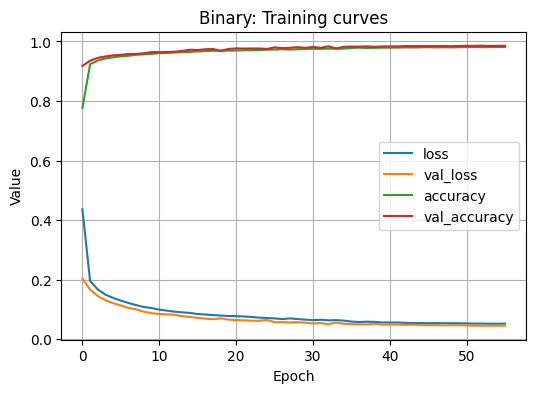


Binary report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     15394
      Attack       0.99      0.99      0.99     14188

    accuracy                           0.99     29582
   macro avg       0.99      0.99      0.99     29582
weighted avg       0.99      0.99      0.99     29582



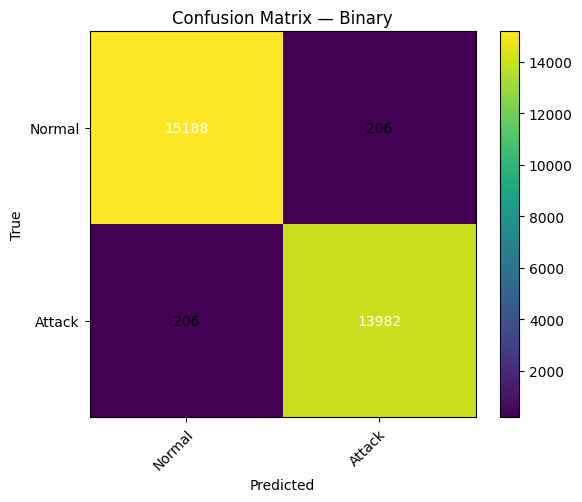

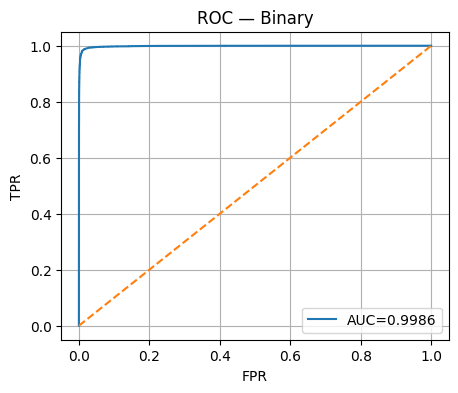

In [31]:

# ==== Binary training (uses NO-LEAK split) ====
USE_SSA = True  # set False to skip tuning
if USE_SSA:
    best = ssa_optimize_fast(X_train, y_trainbin, iters=3, M=4, max_epochs=12, batch=1024, patience=2)
    lstm_units_opt, conv_filters_opt = best["lstm_units"], best["conv_filters"]
else:
    lstm_units_opt, conv_filters_opt = 120, 30

print("Chosen hyperparams:", {"lstm_units": lstm_units_opt, "conv_filters": conv_filters_opt})

# Build datasets
X_tr_seq = np.expand_dims(X_train, 1).astype(np.float32)
X_te_seq = np.expand_dims(X_test, 1).astype(np.float32)

BATCH = 1024; AUTOTUNE = tf.data.AUTOTUNE
VAL_SPLIT = 0.2
N = len(X_tr_seq); n_val = int(N*VAL_SPLIT)
perm = np.random.RandomState(42).permutation(N)
X_tr_seq, y_trbin = X_tr_seq[perm], y_trainbin[perm]
X_val_seq, y_valbin = X_tr_seq[:n_val], y_trbin[:n_val]
X_tr_seq,  y_trbin  = X_tr_seq[n_val:], y_trbin[n_val:]

ds_train = tf.data.Dataset.from_tensor_slices((X_tr_seq, y_trbin)).shuffle(8192, seed=42, reshuffle_each_iteration=True)    .batch(BATCH).cache().prefetch(AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((X_val_seq, y_valbin)).batch(BATCH).cache().prefetch(AUTOTUNE)
ds_test = tf.data.Dataset.from_tensor_slices((X_te_seq, y_testbin)).batch(BATCH).prefetch(AUTOTUNE)

binary_model = build_model(X_tr_seq.shape[-1], conv_filters=conv_filters_opt, lstm_units=lstm_units_opt, n_out=1)
es = callbacks.EarlyStopping(monitor="val_loss", patience=4, min_delta=1e-4, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=0)

with tqdm(total=60, desc="Binary training epochs") as pbar:
    hist = binary_model.fit(ds_train, validation_data=ds_val, epochs=60, verbose=0,
                            callbacks=[es, rlr, callbacks.LambdaCallback(on_epoch_end=lambda e, l: pbar.update(1))])

plot_training(hist, "Binary: Training curves")

probs = np.squeeze(binary_model.predict(ds_test, verbose=0))
preds = (probs >= 0.5).astype(int)
print("\nBinary report:\n", classification_report(y_testbin, preds, target_names=["Normal","Attack"], zero_division=0))
show_confusion(y_testbin, preds, labels=[0,1], class_names=["Normal","Attack"], title="Confusion Matrix — Binary")
fpr, tpr, _ = roc_curve(y_testbin, probs); roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Binary'); plt.legend(); plt.grid(True); plt.show()


Class weights: {0: np.float64(0.5600354977074398), 1: np.float64(0.3836582499088072), 2: np.float64(2.117673378076063), 3: np.float64(7.600160578081092), 4: np.float64(242.71794871794873)}


5-class training (class-weighted):   0%|          | 0/60 [00:00<?, ?it/s]

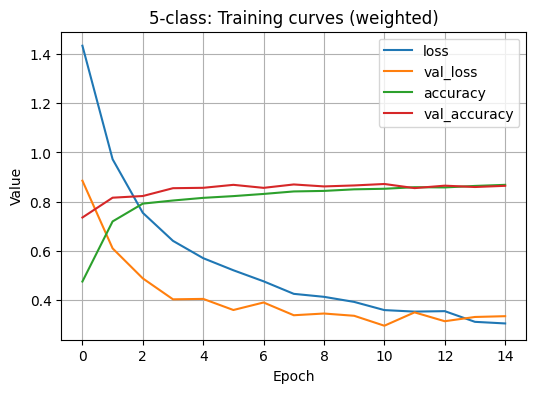


5-class report (weighted):
               precision    recall  f1-score   support

         DoS       0.99      0.95      0.97     10597
      Normal       0.97      0.80      0.87     15394
       Probe       0.81      0.93      0.87      2791
         R2L       0.32      0.93      0.47       776
         U2R       0.01      0.71      0.03        24

    accuracy                           0.87     29582
   macro avg       0.62      0.87      0.64     29582
weighted avg       0.94      0.87      0.90     29582



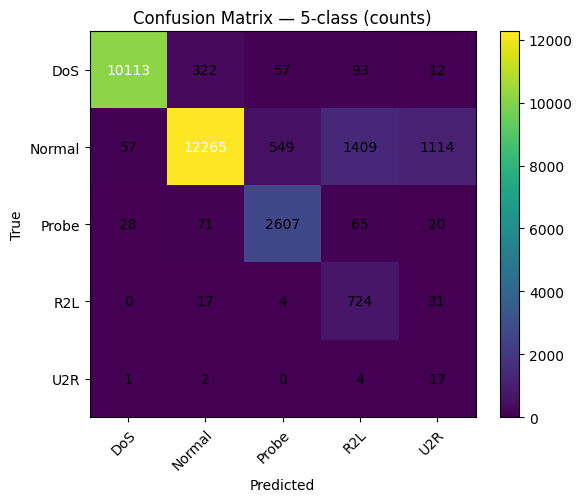

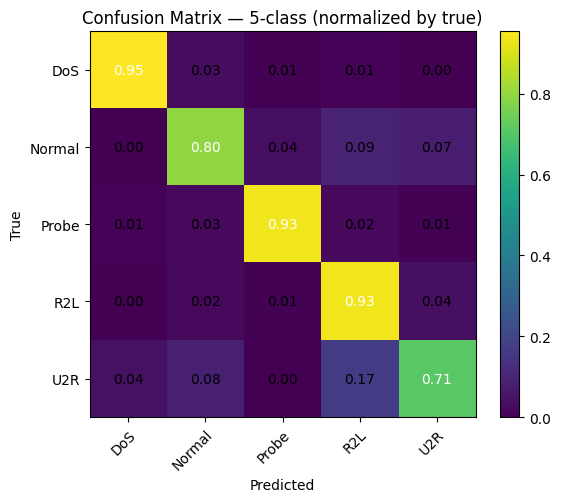

In [32]:

# ==== 5-class training (class-weighted, using NO-LEAK split) ====
label5_cat = df['label_5c'].astype('category')
class_names = list(label5_cat.cat.categories)

X_tr5 = np.expand_dims(X_train, 1).astype(np.float32)
X_te5 = np.expand_dims(X_test, 1).astype(np.float32)
y_tr5, y_te5 = y_train5, y_test5

# Val split from training only
VAL_SPLIT = 0.2
N = len(X_tr5); n_val = int(N * VAL_SPLIT)
perm = np.random.RandomState(42).permutation(N)
X_tr5, y_tr5 = X_tr5[perm], y_tr5[perm]
X_val5, y_val5 = X_tr5[:n_val], y_tr5[:n_val]
X_tr5,  y_tr5  = X_tr5[n_val:], y_tr5[n_val:]

# Class weights on TRAIN labels only
classes = np.unique(y_tr5)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr5)
class_w = dict(zip(map(int, classes), cw))
print("Class weights:", class_w)

# Build sample weights
w_tr5 = np.vectorize(class_w.get)(y_tr5).astype(np.float32)
w_val5 = np.ones_like(y_val5, dtype=np.float32)

BATCH = 1024; AUTOTUNE = tf.data.AUTOTUNE
def ds(X, y, w=None, shuffle=False):
    if w is None: d = tf.data.Dataset.from_tensor_slices((X, y))
    else: d = tf.data.Dataset.from_tensor_slices((X, y, w))
    if shuffle: d = d.shuffle(8192, seed=42, reshuffle_each_iteration=True)
    return d.batch(BATCH).cache().prefetch(AUTOTUNE)

ds_train5 = ds(X_tr5, y_tr5, w_tr5, shuffle=True)
ds_val5   = ds(X_val5, y_val5, w_val5, shuffle=False)
ds_test5  = tf.data.Dataset.from_tensor_slices((X_te5, y_te5)).batch(BATCH).prefetch(AUTOTUNE)

model5 = build_model(X_tr5.shape[-1], conv_filters=conv_filters_opt, lstm_units=lstm_units_opt, n_out=len(class_names))
es5 = callbacks.EarlyStopping(monitor="val_loss", patience=4, min_delta=1e-4, restore_best_weights=True)
rlr5 = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=0)

with tqdm(total=60, desc="5-class training (class-weighted)") as pbar:
    hist5 = model5.fit(ds_train5, validation_data=ds_val5, epochs=60, verbose=0,
                       callbacks=[es5, rlr5, callbacks.LambdaCallback(on_epoch_end=lambda e, l: pbar.update(1))])

plot_training(hist5, "5-class: Training curves (weighted)")

pred5_prob = model5.predict(ds_test5, verbose=0)
pred5 = np.argmax(pred5_prob, axis=1)

print("\n5-class report (weighted):\n",
      classification_report(y_te5, pred5, target_names=class_names, zero_division=0))
show_confusion(y_te5, pred5, labels=list(range(len(class_names))), class_names=class_names,
               title="Confusion Matrix — 5-class (counts)")
show_confusion(y_te5, pred5, labels=list(range(len(class_names))), class_names=class_names,
               title="Confusion Matrix — 5-class (normalized by true)", normalize='true')
